# RNN model for Emotion Classification

## **Data preprocessing**

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Core libraries
import numpy as np
import pandas as pd
import json
import joblib
from pathlib import Path

# Define data paths
SEQ_PATH   = Path("artifacts/features/sequences/")
LABEL_PATH = Path("artifacts/labels/")
DENSE_PATH = Path("artifacts/features/dense/")

print("Environment ready.")

Environment ready.


In [3]:
# Load tokenized sequences
X_train_seq = np.load(SEQ_PATH / "X_train_seq_v1.npz")["arr_0"]
X_valid_seq = np.load(SEQ_PATH / "X_valid_seq_v1.npz")["arr_0"]
X_test_seq  = np.load(SEQ_PATH / "X_test_seq_v1.npz")["arr_0"]

# Check shapes and sequence length
print(f"Seq shapes — train:{X_train_seq.shape}, valid:{X_valid_seq.shape}, test:{X_test_seq.shape}")
print(f"Max seq length: {X_train_seq.shape[1]}")

Seq shapes — train:(109816, 65), valid:(6102, 65), test:(6102, 65)
Max seq length: 65


In [4]:
# Count non-padding tokens in training sequences
non_zero = np.count_nonzero(X_train_seq, axis=1)
print(f"Train non-pad length — mean:{non_zero.mean():.2f}, min:{non_zero.min()}, max:{non_zero.max()}")

# Check highest token index in training data
print(f"Max token index in train: {int(X_train_seq.max())}")

Train non-pad length — mean:16.95, min:0, max:65
Max token index in train: 39999


In [5]:
# Load training tokenizer
tokenizer = joblib.load(SEQ_PATH / "tokenizer_v1.joblib")

# Load sequence metadata
with open(SEQ_PATH / "sequence_meta_v1.txt", "r") as f:
    meta_txt = f.read()

# Print tokenizer size and metadata
print(f"Tokenizer size (unique indices): {len(tokenizer.word_index)}")
print("Meta:", meta_txt.strip().replace("\n", " | "))

2025-10-05 12:17:26.040491: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tokenizer size (unique indices): 46273
Meta: VOCAB_SIZE=40000 | MAX_LEN=65


In [6]:
# Load label data
y_train = pd.read_csv(LABEL_PATH / "y_train_v1.csv")
y_valid = pd.read_csv(LABEL_PATH / "y_valid_v1.csv")
y_test  = pd.read_csv(LABEL_PATH / "y_test_v1.csv")

# Get label column name
label_col = y_train.columns[0]

# Check label shapes
print(f"Label shapes — train:{y_train.shape}, valid:{y_valid.shape}, test:{y_test.shape}")

# Show training label distribution
train_counts = y_train[label_col].value_counts().sort_index()
print("Train class counts:", train_counts.to_dict())

Label shapes — train:(109815, 1), valid:(6101, 1), test:(6101, 1)
Train class counts: {0: 14800, 1: 2174, 2: 3953, 3: 31351, 4: 36691, 5: 9130, 6: 11716}


In [7]:
# Load mapping from emotion labels to numeric IDs
with open(LABEL_PATH / "label_mapping_v1.json", "r") as f:
    label_mapping = json.load(f)

# Create reverse mapping (ID → label)
id_to_emotion = {v: k for k, v in label_mapping.items()}

# Show all classes
print("Classes:", {i: id_to_emotion[i] for i in sorted(id_to_emotion)})

Classes: {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'neutral', 5: 'sadness', 6: 'surprise'}


In [8]:
# Load dense features
dense_features = pd.read_parquet(DENSE_PATH / "dense_features_v1.parquet", engine="pyarrow")

# Load feature column names
with open(DENSE_PATH / "dense_feature_columns_v1.json", "r") as f:
    feature_columns = json.load(f)

# Load scaler from training
scaler = joblib.load(DENSE_PATH / "dense_scaler_v1.joblib")

# Check dense feature shape
print(f"Dense features: {dense_features.shape}, n_cols={len(feature_columns)}")

Dense features: (122017, 22), n_cols=22


In [9]:
# Split dense features by explicit 'split' column or by row order
if "split" in dense_features.columns:
    train_dense = dense_features[dense_features["split"] == "train"][feature_columns]
    valid_dense = dense_features[dense_features["split"] == "valid"][feature_columns]
    test_dense  = dense_features[dense_features["split"] == "test"][feature_columns]
else:
    n_train, n_valid = len(y_train), len(y_valid)
    train_dense = dense_features.iloc[:n_train][feature_columns]
    valid_dense = dense_features.iloc[n_train:n_train+n_valid][feature_columns]
    test_dense  = dense_features.iloc[n_train+n_valid:][feature_columns]

# Check split sizes
print(f"Dense split — train:{train_dense.shape}, valid:{valid_dense.shape}, test:{test_dense.shape}")

Dense split — train:(109815, 22), valid:(6101, 22), test:(6101, 22)


In [10]:
# Verify sequence and label counts match
def _ok(x, y): return x == y
print("Seq/label match:",
      dict(train=_ok(X_train_seq.shape[0], len(y_train)),
           valid=_ok(X_valid_seq.shape[0], len(y_valid)),
           test=_ok(X_test_seq.shape[0], len(y_test))))

# Trim sequences if counts differ
if X_train_seq.shape[0] != len(y_train):
    X_train_seq = X_train_seq[:len(y_train)]
if X_valid_seq.shape[0] != len(y_valid):
    X_valid_seq = X_valid_seq[:len(y_valid)]
if X_test_seq.shape[0] != len(y_test):
    X_test_seq = X_test_seq[:len(y_test)]

# Print final shapes after adjustment
print(f"Post-fix shapes — train:{X_train_seq.shape}, valid:{X_valid_seq.shape}, test:{X_test_seq.shape}")

Seq/label match: {'train': False, 'valid': False, 'test': False}
Post-fix shapes — train:(109815, 65), valid:(6101, 65), test:(6101, 65)


In [11]:
# Remove empty (all-padding) rows from training set
train_nonempty_mask = np.count_nonzero(X_train_seq, axis=1) > 0
X_train_seq = X_train_seq[train_nonempty_mask]
y_train = y_train.loc[train_nonempty_mask].reset_index(drop=True)
train_dense = train_dense.loc[train_nonempty_mask].reset_index(drop=True)

# Check shapes after cleanup
print(f"Train after removing empties: {X_train_seq.shape}, labels:{y_train.shape}, dense:{train_dense.shape}")

Train after removing empties: (109811, 65), labels:(109811, 1), dense:(109811, 22)


In [12]:
# Load external test data
new_test_data = pd.read_csv("group_8_url_1_transcript.csv")

# Select text column (set to 'Sentence' if training was on Arabic)
TEXT_COLUMN = "Translation"

# Check dataset size and chosen column
print(f"External samples: {len(new_test_data)}, text column: '{TEXT_COLUMN}'")

External samples: 5994, text column: 'Translation'


In [13]:
# Load external test data
new_test_data = pd.read_csv("group_8_url_1_transcript.csv")

# Choose text column (match training language)
TEXT_COLUMN = "Translation"

# Print dataset info
print(f"External samples: {len(new_test_data)}, text column: '{TEXT_COLUMN}'")

External samples: 5994, text column: 'Translation'


In [14]:
# Preview first 3 rows of each column
print("Sample data from each column:\n")
for col in new_test_data.columns:
    print(f"\n{col}:")
    print(new_test_data[col].head(3))
    print("-" * 50)

Sample data from each column:


Start Time:
0    1900-01-01 00:00:00
1    1900-01-01 00:00:02
2    1900-01-01 00:00:04
Name: Start Time, dtype: object
--------------------------------------------------

End Time:
0    1900-01-01 00:00:02
1    1900-01-01 00:00:04
2    1900-01-01 00:00:05
Name: End Time, dtype: object
--------------------------------------------------

Sentence:
0    لا يوجد علاقة بدون حاجة
1                      قاعدة
2              لا يوجد علاقة
Name: Sentence, dtype: object
--------------------------------------------------

Translation:
0    There is no relationship without need
1                                     Base
2                 There is no relationship
Name: Translation, dtype: object
--------------------------------------------------

Emotion_fine:
0    resignation
1     neutrality
2     detachment
Name: Emotion_fine, dtype: object
--------------------------------------------------

Emotion_core:
0    neutral
1    neutral
2    neutral
Name: Emotion_core, 

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize external test text
test_texts = new_test_data[TEXT_COLUMN].fillna("").astype(str).tolist()
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad/truncate to match training sequence length
SEQ_LEN = X_train_seq.shape[1]
X_new_test = pad_sequences(test_sequences, maxlen=SEQ_LEN, padding="post", truncating="post")

# Check shape
print(f"External tokenized shape: {X_new_test.shape} (seq_len={SEQ_LEN})")

External tokenized shape: (5994, 65) (seq_len=65)


In [16]:
# Pick emotion column (core or fine) based on mapping coverage
if set(new_test_data.get("Emotion_core", [])).issubset(set(label_mapping.keys())):
    EMOTION_COL = "Emotion_core"
elif set(new_test_data.get("Emotion_fine", [])).issubset(set(label_mapping.keys())):
    EMOTION_COL = "Emotion_fine"
else:
    EMOTION_COL = "Emotion_core"

# Map emotion labels to IDs, mark unknowns as -1
y_new_test = []
for emo in new_test_data[EMOTION_COL].astype(str):
    y_new_test.append(label_mapping.get(emo, -1))
y_new_test = np.array(y_new_test, dtype=int)

# Keep only valid labels
valid_mask = y_new_test >= 0
X_new_test_valid = X_new_test[valid_mask]
y_new_test_valid = y_new_test[valid_mask]

# Check label counts
print(f"External labels: total={len(y_new_test)}, valid={valid_mask.sum()}, unknown={(~valid_mask).sum()}")
print(f"Emotion column used: {EMOTION_COL}")

External labels: total=5994, valid=5994, unknown=0
Emotion column used: Emotion_core


In [17]:
# Quick summary of data shapes and counts
summary = {
    "train_seq": X_train_seq.shape,
    "valid_seq": X_valid_seq.shape,
    "test_seq":  X_test_seq.shape,
    "dense_cols": len(feature_columns),
    "new_test_seq": X_new_test.shape,
    "new_test_valid": X_new_test_valid.shape[0],
    "n_classes": len(label_mapping),
}

# Show summary
summary

{'train_seq': (109811, 65),
 'valid_seq': (6101, 65),
 'test_seq': (6101, 65),
 'dense_cols': 22,
 'new_test_seq': (5994, 65),
 'new_test_valid': 5994,
 'n_classes': 7}

In [18]:
# Save external test set artifacts for later prediction/evaluation
new_test_data.assign(
    is_valid=valid_mask,
    numeric_label=y_new_test
).to_csv("test_data_prepared.csv", index=False)

np.savez_compressed("X_new_test.npz", X_new_test_valid)
np.save("y_new_test.npy", y_new_test_valid)

print("Saved: test_data_prepared.csv, X_new_test.npz, y_new_test.npy")


Saved: test_data_prepared.csv, X_new_test.npz, y_new_test.npy


In [21]:
# Convenience arrays for labels
ytr = y_train[label_col].astype(int).values
yva = y_valid[label_col].astype(int).values
yte = y_test[label_col].astype(int).values

# Helper to compute class distribution
def dist(y, name):
    vc = pd.Series(y).value_counts().sort_index()
    df = pd.DataFrame({
        "class_id": vc.index,
        "emotion": [id_to_emotion[i] for i in vc.index],
        "count": vc.values
    })
    df["percent"] = (df["count"] / df["count"].sum() * 100).round(2)
    df["rank"] = df["count"].rank(ascending=False, method="min").astype(int)
    df["split"] = name
    return df

# Distributions for each split
dist_train = dist(ytr, "train")
dist_valid = dist(yva, "valid")
dist_test  = dist(yte, "test")

# Combined distribution
dist_all = pd.concat([dist_train, dist_valid, dist_test], ignore_index=True)
dist_train, dist_valid, dist_test, dist_all.head(10)

(   class_id    emotion  count  percent  rank  split
 0         0      anger  14799    13.48     3  train
 1         1    disgust   2174     1.98     7  train
 2         2       fear   3953     3.60     6  train
 3         3  happiness  31351    28.55     2  train
 4         4    neutral  36688    33.41     1  train
 5         5    sadness   9130     8.31     5  train
 6         6   surprise  11716    10.67     4  train,
    class_id    emotion  count  percent  rank  split
 0         0      anger    822    13.47     3  valid
 1         1    disgust    121     1.98     7  valid
 2         2       fear    219     3.59     6  valid
 3         3  happiness   1742    28.55     2  valid
 4         4    neutral   2039    33.42     1  valid
 5         5    sadness    507     8.31     5  valid
 6         6   surprise    651    10.67     4  valid,
    class_id    emotion  count  percent  rank split
 0         0      anger    822    13.47     3  test
 1         1    disgust    121     1.98     7 

In [22]:
# Helper to summarize imbalance in a distribution
def imbalance_report(df):
    cmax = df["count"].max()
    cmin = df["count"].min()
    ratio = cmax / max(cmin, 1)
    return {
        "n_classes": df.shape[0],
        "max_class": df.loc[df["count"].idxmax(), ["class_id", "emotion", "count"]].to_dict(),
        "min_class": df.loc[df["count"].idxmin(), ["class_id", "emotion", "count"]].to_dict(),
        "imbalance_ratio_max_min": round(ratio, 2)
    }

# Reports for each split
imb_train = imbalance_report(dist_train)
imb_valid = imbalance_report(dist_valid)
imb_test  = imbalance_report(dist_test)

# Print results
print("Train:", imb_train)
print("Valid:", imb_valid)
print("Test :", imb_test)

Train: {'n_classes': 7, 'max_class': {'class_id': 4, 'emotion': 'neutral', 'count': 36688}, 'min_class': {'class_id': 1, 'emotion': 'disgust', 'count': 2174}, 'imbalance_ratio_max_min': np.float64(16.88)}
Valid: {'n_classes': 7, 'max_class': {'class_id': 4, 'emotion': 'neutral', 'count': 2039}, 'min_class': {'class_id': 1, 'emotion': 'disgust', 'count': 121}, 'imbalance_ratio_max_min': np.float64(16.85)}
Test : {'n_classes': 7, 'max_class': {'class_id': 4, 'emotion': 'neutral', 'count': 2038}, 'min_class': {'class_id': 1, 'emotion': 'disgust', 'count': 121}, 'imbalance_ratio_max_min': np.float64(16.84)}


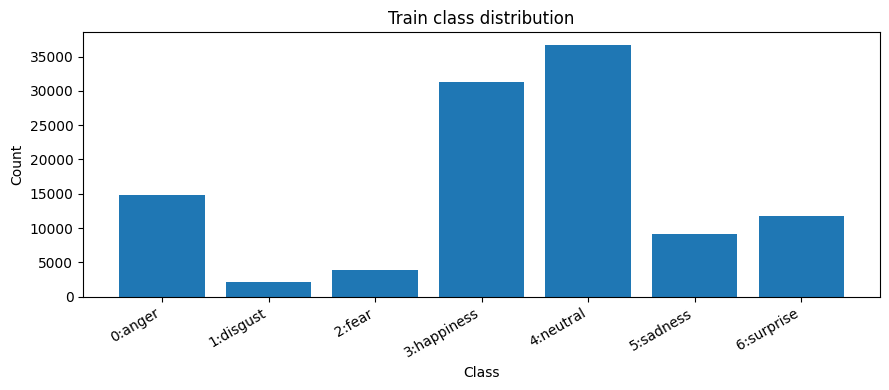

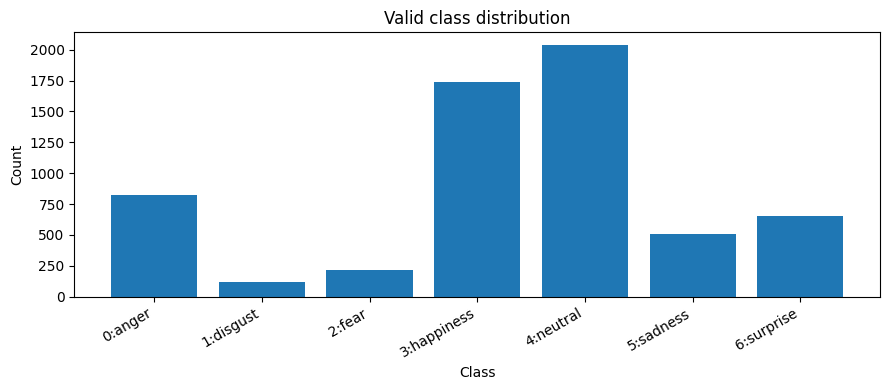

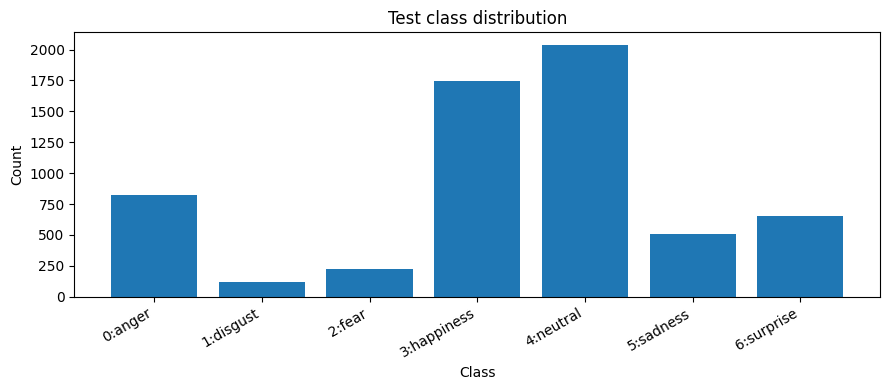

In [23]:
import matplotlib.pyplot as plt

# Plot class counts for a split
def plot_counts(df, title):
    df = df.sort_values("class_id")
    labels = [f'{i}:{id_to_emotion[i]}' for i in df["class_id"]]
    counts = df["count"].values

    plt.figure(figsize=(9,4))
    plt.bar(labels, counts)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

# Plot distributions
plot_counts(dist_train, "Train class distribution")
plot_counts(dist_valid, "Valid class distribution")
plot_counts(dist_test,  "Test class distribution")

## Iterations

### First Iteration

In [24]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [25]:
# Define model hyperparameters
VOCAB_SIZE = 40000
EMBEDDING_DIM = 128
RNN_UNITS = 128
MAX_LEN = 65
NUM_CLASSES = 7
DROPOUT_RATE = 0.3

In [26]:
# One-hot encode labels
y_train_cat = to_categorical(y_train[label_col].values, num_classes=NUM_CLASSES)
y_valid_cat = to_categorical(y_valid[label_col].values, num_classes=NUM_CLASSES)
y_test_cat = to_categorical(y_test[label_col].values, num_classes=NUM_CLASSES)

In [28]:
# Build simple RNN model
def build_rnn_model():
    model = models.Sequential([
        layers.Embedding(input_dim=VOCAB_SIZE + 1, 
                         output_dim=EMBEDDING_DIM, 
                         input_length=MAX_LEN,
                         mask_zero=True),
        layers.LSTM(RNN_UNITS, return_sequences=False),
        layers.Dropout(DROPOUT_RATE),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

# Initialize and show model
model.build(input_shape=(None, MAX_LEN))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 65, 128)        │     5,120,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,252,615 (20.04 MB)

 Trainable params: 5,252,615 (20.04 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [30]:
# Configure training callbacks for early stopping and learning rate reduction
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

In [32]:
# Training callbacks
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

Epoch 1/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 68s 79ms/step - accuracy: 0.3327 - loss: 1.6410 - val_accuracy: 0.3334 - val_loss: 1.6403 - learning_rate: 0.0010
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 72s 83ms/step - accuracy: 0.3611 - loss: 1.5964 - val_accuracy: 0.3239 - val_loss: 1.6694 - learning_rate: 0.0010
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4172 - loss: 1.4672
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
858/858 ━━━━━━━━━━━━━━━━━━━━ 52s 59ms/step - accuracy: 0.4042 - loss: 1.4859 - val_accuracy: 0.3024 - val_loss: 1.7773 - learning_rate: 0.0010
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 52s 60ms/step - accuracy: 0.4631 - loss: 1.3050 - val_accuracy: 0.2806 - val_loss: 2.0035 - learning_rate: 5.0000e-04
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [33]:
# Evaluate model performance on test set
test_loss, test_acc = model.evaluate(X_test_seq, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.3322
Test Loss: 1.6419


In [36]:
# Evaluate model on external test set with detailed metrics
from sklearn.metrics import f1_score

y_new_pred = model.predict(X_new_test_valid, verbose=0)
y_new_pred_classes = np.argmax(y_new_pred, axis=1)

# Calculate F1 scores
f1_macro = f1_score(y_new_test_valid, y_new_pred_classes, average='macro')
f1_weighted = f1_score(y_new_test_valid, y_new_pred_classes, average='weighted')

print("External Test Set Performance:")
print(f"Macro F1 Score: {f1_macro:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}\n")

print(classification_report(
    y_new_test_valid,
    y_new_pred_classes,
    target_names=[id_to_emotion[i] for i in range(NUM_CLASSES)],
    digits=4
))

External Test Set Performance:
Macro F1 Score: 0.1051
Weighted F1 Score: 0.3641

              precision    recall  f1-score   support

       anger     0.0000    0.0000    0.0000       406
     disgust     0.0000    0.0000    0.0000       214
        fear     0.0000    0.0000    0.0000       292
   happiness     0.1260    0.0378    0.0581       847
     neutral     0.5248    0.9571    0.6779      3147
     sadness     0.0000    0.0000    0.0000       841
    surprise     0.0000    0.0000    0.0000       247

    accuracy                         0.5078      5994
   macro avg     0.0930    0.1421    0.1051      5994
weighted avg     0.2934    0.5078    0.3641      5994



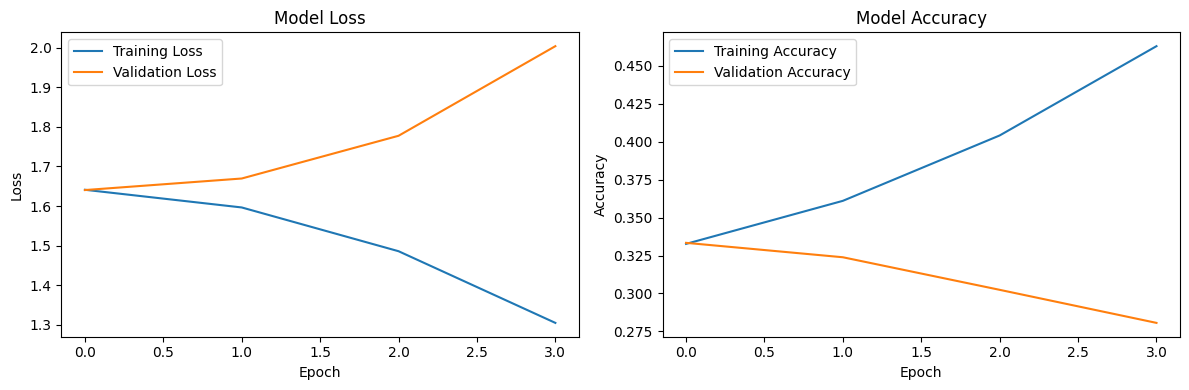

In [37]:
# Visualize training history: loss and accuracy curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

==================== ITERATION 2: IMPROVED RNN MODEL ====================
Addressing class imbalance and improving architecture
Import additional utilities for handling imbalanced data

In [39]:
# Imports for class weights and F1 metric
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score

In [40]:
# Calculate class weights to address imbalance
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train[label_col]),
    y=y_train[label_col]
)
class_weight_dict = dict(enumerate(class_weights))

# Display class weights for transparency
for class_id, weight in class_weight_dict.items():
    emotion_name = id_to_emotion[class_id]
    print(f"{emotion_name:12s}: {weight:.3f}")

anger       : 1.060
disgust     : 7.216
fear        : 3.968
happiness   : 0.500
neutral     : 0.428
sadness     : 1.718
surprise    : 1.339


In [46]:
# Updated hyperparameters for improved model
VOCAB_SIZE_V2 = 40000
EMBEDDING_DIM_V2 = 128
RNN_UNITS_V2 = 128
MAX_LEN_V2 = 65
NUM_CLASSES_V2 = 7
DROPOUT_RATE_V2 = 0.5
BATCH_SIZE_V2 = 128
EPOCHS_V2 = 25

In [47]:
# Build improved architecture with bidirectional LSTM and deeper network
def build_improved_rnn():
    model = models.Sequential([
        # Embedding layer with masking for variable-length sequences
        layers.Embedding(input_dim=VOCAB_SIZE_V2 + 1, 
                        output_dim=EMBEDDING_DIM_V2, 
                        input_length=MAX_LEN_V2,
                        mask_zero=True),
        
        # First bidirectional LSTM layer with return sequences
        layers.Bidirectional(layers.LSTM(RNN_UNITS_V2, return_sequences=True)),
        layers.Dropout(DROPOUT_RATE_V2),
        
        # Second bidirectional LSTM layer
        layers.Bidirectional(layers.LSTM(RNN_UNITS_V2 // 2)),
        layers.Dropout(DROPOUT_RATE_V2),
        
        # Dense layer for additional feature learning
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        
        # Output layer
        layers.Dense(NUM_CLASSES_V2, activation='softmax')
    ])
    return model

model_v2 = build_improved_rnn()
model_v2.build(input_shape=(None, MAX_LEN_V2))
model_v2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 65, 128)        │     5,120,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 65, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 65, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,556,359 (21.20 MB)

 Trainable params: 5,556,359 (21.20 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Compile model with same configuration as baseline
model_v2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [49]:
# Configure callbacks with adjusted patience
early_stop_v2 = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_v2 = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [50]:
# Train improved model with class weights
history_v2 = model_v2.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_valid_seq, y_valid_cat),
    batch_size=BATCH_SIZE_V2,
    epochs=EPOCHS_V2,
    class_weight=class_weight_dict,
    callbacks=[early_stop_v2, reduce_lr_v2],
    verbose=1
)

Epoch 1/25
858/858 ━━━━━━━━━━━━━━━━━━━━ 92s 101ms/step - accuracy: 0.1338 - loss: 1.9469 - val_accuracy: 0.2337 - val_loss: 1.9375 - learning_rate: 0.0010
Epoch 2/25
858/858 ━━━━━━━━━━━━━━━━━━━━ 85s 99ms/step - accuracy: 0.1252 - loss: 1.9429 - val_accuracy: 0.1047 - val_loss: 1.9457 - learning_rate: 0.0010
Epoch 3/25
858/858 ━━━━━━━━━━━━━━━━━━━━ 87s 101ms/step - accuracy: 0.1430 - loss: 1.8694 - val_accuracy: 0.0846 - val_loss: 1.9606 - learning_rate: 0.0010
Epoch 4/25
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.2088 - loss: 1.6477
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
858/858 ━━━━━━━━━━━━━━━━━━━━ 88s 102ms/step - accuracy: 0.2025 - loss: 1.6680 - val_accuracy: 0.1041 - val_loss: 2.0040 - learning_rate: 0.0010
Epoch 5/25
858/858 ━━━━━━━━━━━━━━━━━━━━ 87s 101ms/step - accuracy: 0.2850 - loss: 1.3995 - val_accuracy: 0.1097 - val_loss: 2.1345 - learning_rate: 5.0000e-04
Epoch 6/25
858/858 ━━━━━━━━━━━━━━━━━━━━ 87s 100ms/step - accuracy: 0.3

In [51]:
# Evaluate on test set
test_loss_v2, test_acc_v2 = model_v2.evaluate(X_test_seq, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_acc_v2:.4f}")
print(f"Test Loss: {test_loss_v2:.4f}")

Test Accuracy: 0.2280
Test Loss: 1.9376


In [52]:
# Evaluate on external test set with F1 scores
y_new_pred_v2 = model_v2.predict(X_new_test_valid, verbose=0)
y_new_pred_classes_v2 = np.argmax(y_new_pred_v2, axis=1)

f1_macro_v2 = f1_score(y_new_test_valid, y_new_pred_classes_v2, average='macro')
f1_weighted_v2 = f1_score(y_new_test_valid, y_new_pred_classes_v2, average='weighted')

print("=" * 60)
print("IMPROVED MODEL - EXTERNAL TEST SET PERFORMANCE")
print("=" * 60)
print(f"Macro F1 Score: {f1_macro_v2:.4f}")
print(f"Weighted F1 Score: {f1_weighted_v2:.4f}\n")

print(classification_report(
    y_new_test_valid,
    y_new_pred_classes_v2,
    target_names=[id_to_emotion[i] for i in range(NUM_CLASSES_V2)],
    digits=4
))

IMPROVED MODEL - EXTERNAL TEST SET PERFORMANCE
Macro F1 Score: 0.0769
Weighted F1 Score: 0.0962

              precision    recall  f1-score   support

       anger     0.0792    0.0788    0.0790       406
     disgust     0.0303    0.0561    0.0393       214
        fear     0.0000    0.0000    0.0000       292
   happiness     0.1394    0.6671    0.2307       847
     neutral     0.5958    0.0543    0.0996      3147
     sadness     0.1176    0.0048    0.0091       841
    surprise     0.0524    0.1741    0.0805       247

    accuracy                         0.1380      5994
   macro avg     0.1450    0.1479    0.0769      5994
weighted avg     0.3576    0.1380    0.0962      5994



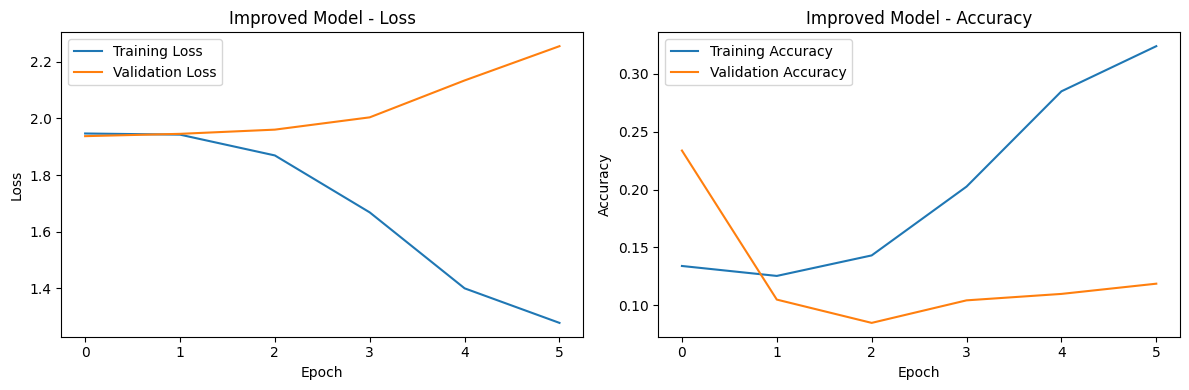

In [53]:
# Visualize training history for improved model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_v2.history['loss'], label='Training Loss')
plt.plot(history_v2.history['val_loss'], label='Validation Loss')
plt.title('Improved Model - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_v2.history['accuracy'], label='Training Accuracy')
plt.plot(history_v2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Improved Model - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

==================== ITERATION 3: BALANCED APPROACH ====================
 Strategy: GRU architecture + moderate class weights + batch normalization
 Calculate moderate class weights (less aggressive)

In [55]:
from sklearn.utils.class_weight import compute_class_weight

# Use square root of balanced weights for gentler correction
class_weights_v3 = compute_class_weight(
    'balanced',
    classes=np.unique(y_train[label_col]),
    y=y_train[label_col]
)
# Apply square root to make weights less extreme
class_weights_v3 = np.sqrt(class_weights_v3)
class_weight_dict_v3 = dict(enumerate(class_weights_v3))

print("Moderate Class Weights:")
for class_id, weight in class_weight_dict_v3.items():
    emotion_name = id_to_emotion[class_id]
    print(f"{emotion_name:12s}: {weight:.3f}")

Moderate Class Weights:
anger       : 1.030
disgust     : 2.686
fear        : 1.992
happiness   : 0.707
neutral     : 0.654
sadness     : 1.311
surprise    : 1.157


In [56]:
# Hyperparameters for iteration 3
VOCAB_SIZE_V3 = 40000
EMBEDDING_DIM_V3 = 256
GRU_UNITS_V3 = 256
MAX_LEN_V3 = 65
NUM_CLASSES_V3 = 7
DROPOUT_RATE_V3 = 0.4
BATCH_SIZE_V3 = 128
EPOCHS_V3 = 30

In [57]:
# Build GRU-based model with batch normalization
def build_gru_model():
    model = models.Sequential([
        # Embedding layer
        layers.Embedding(input_dim=VOCAB_SIZE_V3 + 1, 
                        output_dim=EMBEDDING_DIM_V3, 
                        input_length=MAX_LEN_V3,
                        mask_zero=True),
        
        # First GRU layer (faster than LSTM, often comparable performance)
        layers.Bidirectional(layers.GRU(GRU_UNITS_V3, return_sequences=True)),
        layers.BatchNormalization(),
        layers.Dropout(DROPOUT_RATE_V3),
        
        # Second GRU layer
        layers.Bidirectional(layers.GRU(GRU_UNITS_V3 // 2)),
        layers.BatchNormalization(),
        layers.Dropout(DROPOUT_RATE_V3),
        
        # Dense layers
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        
        # Output layer
        layers.Dense(NUM_CLASSES_V3, activation='softmax')
    ])
    return model

model_v3 = build_gru_model()
model_v3.build(input_shape=(None, MAX_LEN_V3))
model_v3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 65, 256)        │    10,240,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 65, 512)        │       789,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 65, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 65, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 256)            │       493,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,568,007 (44.13 MB)

 Trainable params: 11,566,215 (44.12 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [58]:
# Compile with lower learning rate for stability
from tensorflow.keras.optimizers import Adam

optimizer_v3 = Adam(learning_rate=0.0005)

model_v3.compile(
    optimizer=optimizer_v3,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [59]:
# Configure callbacks with longer patience
early_stop_v3 = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_v3 = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Add model checkpoint to save best model
checkpoint_v3 = callbacks.ModelCheckpoint(
    'rnn_best_v3.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [60]:
# Train with moderate class weights
history_v3 = model_v3.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_valid_seq, y_valid_cat),
    batch_size=BATCH_SIZE_V3,
    epochs=EPOCHS_V3,
    class_weight=class_weight_dict_v3,
    callbacks=[early_stop_v3, reduce_lr_v3, checkpoint_v3],
    verbose=1
)

Epoch 1/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2267 - loss: 1.9385
Epoch 1: val_accuracy improved from None to 0.29749, saving model to rnn_best_v3.h5


858/858 ━━━━━━━━━━━━━━━━━━━━ 58s 62ms/step - accuracy: 0.2497 - loss: 1.8363 - val_accuracy: 0.2975 - val_loss: 1.7750 - learning_rate: 5.0000e-04
Epoch 2/30
857/858 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2975 - loss: 1.7195
Epoch 2: val_accuracy improved from 0.29749 to 0.32126, saving model to rnn_best_v3.h5


858/858 ━━━━━━━━━━━━━━━━━━━━ 50s 57ms/step - accuracy: 0.3030 - loss: 1.7182 - val_accuracy: 0.3213 - val_loss: 1.7400 - learning_rate: 5.0000e-04
Epoch 3/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3163 - loss: 1.7028
Epoch 3: val_accuracy improved from 0.32126 to 0.33027, saving model to rnn_best_v3.h5


858/858 ━━━━━━━━━━━━━━━━━━━━ 49s 57ms/step - accuracy: 0.3183 - loss: 1.6989 - val_accuracy: 0.3303 - val_loss: 1.7420 - learning_rate: 5.0000e-04
Epoch 4/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3262 - loss: 1.6784
Epoch 4: val_accuracy did not improve from 0.33027
858/858 ━━━━━━━━━━━━━━━━━━━━ 48s 56ms/step - accuracy: 0.3242 - loss: 1.6787 - val_accuracy: 0.3263 - val_loss: 1.7355 - learning_rate: 5.0000e-04
Epoch 5/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3182 - loss: 1.6283
Epoch 5: val_accuracy did not improve from 0.33027
858/858 ━━━━━━━━━━━━━━━━━━━━ 65s 75ms/step - accuracy: 0.3131 - loss: 1.6384 - val_accuracy: 0.3083 - val_loss: 1.7397 - learning_rate: 5.0000e-04
Epoch 6/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.3116 - loss: 1.5526
Epoch 6: val_accuracy did not improve from 0.33027
858/858 ━━━━━━━━━━━━━━━━━━━━ 84s 97ms/step - accuracy: 0.3037 - loss: 1.5635 - val_accuracy: 0.2137 - val_loss: 1.8171 - learning_rate: 5.0000e-0

In [61]:
# Evaluate on test set
test_loss_v3, test_acc_v3 = model_v3.evaluate(X_test_seq, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_acc_v3:.4f}")
print(f"Test Loss: {test_loss_v3:.4f}")

Test Accuracy: 0.3249
Test Loss: 1.7353


In [62]:
# External test set evaluation
y_new_pred_v3 = model_v3.predict(X_new_test_valid, verbose=0)
y_new_pred_classes_v3 = np.argmax(y_new_pred_v3, axis=1)

f1_macro_v3 = f1_score(y_new_test_valid, y_new_pred_classes_v3, average='macro')
f1_weighted_v3 = f1_score(y_new_test_valid, y_new_pred_classes_v3, average='weighted')

print("=" * 60)
print("ITERATION 3 - EXTERNAL TEST SET PERFORMANCE")
print("=" * 60)
print(f"Macro F1 Score: {f1_macro_v3:.4f}")
print(f"Weighted F1 Score: {f1_weighted_v3:.4f}\n")

print(classification_report(
    y_new_test_valid,
    y_new_pred_classes_v3,
    target_names=[id_to_emotion[i] for i in range(NUM_CLASSES_V3)],
    digits=4
))

ITERATION 3 - EXTERNAL TEST SET PERFORMANCE
Macro F1 Score: 0.1104
Weighted F1 Score: 0.3584

              precision    recall  f1-score   support

       anger     0.0000    0.0000    0.0000       406
     disgust     0.0000    0.0000    0.0000       214
        fear     0.0000    0.0000    0.0000       292
   happiness     0.1361    0.1122    0.1230       847
     neutral     0.5185    0.8691    0.6495      3147
     sadness     0.0000    0.0000    0.0000       841
    surprise     0.0000    0.0000    0.0000       247

    accuracy                         0.4721      5994
   macro avg     0.0935    0.1402    0.1104      5994
weighted avg     0.2914    0.4721    0.3584      5994



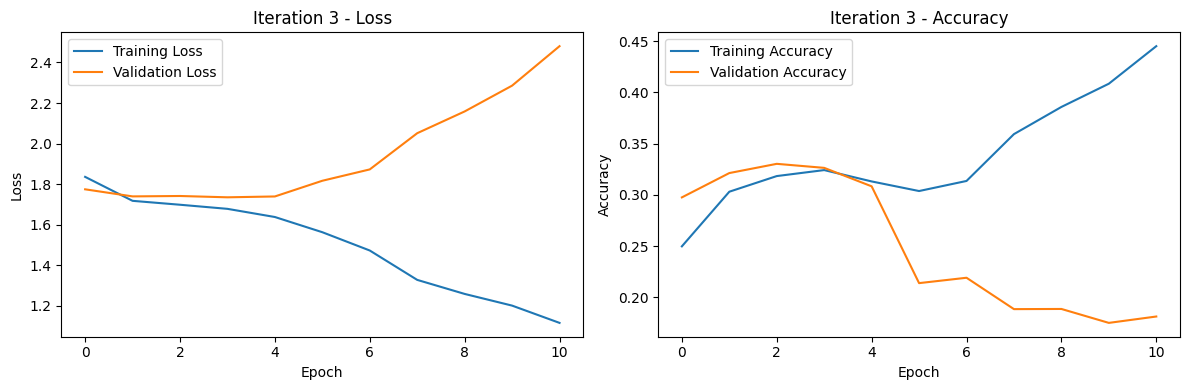

In [63]:
# Visualize training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_v3.history['loss'], label='Training Loss')
plt.plot(history_v3.history['val_loss'], label='Validation Loss')
plt.title('Iteration 3 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_v3.history['accuracy'], label='Training Accuracy')
plt.plot(history_v3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Iteration 3 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

==================== ITERATION 4: FINAL OPTIMIZATION ====================
 Strategy: Focal Loss + SMOTE-like oversampling + Attention mechanism
Implement Focal Loss to heavily penalize misclassified minority classes

In [64]:

import tensorflow.keras.backend as K

def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal loss addresses class imbalance by down-weighting easy examples
    and focusing on hard, misclassified examples
    """
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * y_true * K.pow((1 - y_pred), gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

In [66]:
# Oversample minority classes using simple duplication
def oversample_minority_classes(X, y, target_samples=10000):
    """
    Duplicate samples from minority classes to balance the dataset
    """
    X_resampled = []
    y_resampled = []
    
    # Convert y to numpy array if it's a DataFrame
    y_array = y[label_col].values if hasattr(y, 'columns') else y
    
    for class_id in range(NUM_CLASSES):
        # Get samples for this class
        class_mask = y_array == class_id
        X_class = X[class_mask]
        y_class = y_array[class_mask]
        
        current_samples = len(X_class)
        
        if current_samples < target_samples:
            # Oversample by repeating samples
            repeats = target_samples // current_samples + 1
            X_class = np.tile(X_class, (repeats, 1))[:target_samples]
            y_class = np.tile(y_class, repeats)[:target_samples]
        
        X_resampled.append(X_class)
        y_resampled.append(y_class)
    
    X_resampled = np.vstack(X_resampled)
    y_resampled = np.concatenate(y_resampled)
    
    # Shuffle the data
    indices = np.random.permutation(len(X_resampled))
    return X_resampled[indices], y_resampled[indices]

# Apply oversampling to training data
X_train_balanced, y_train_balanced = oversample_minority_classes(
    X_train_seq, y_train, target_samples=10000
)
y_train_balanced_cat = to_categorical(y_train_balanced, num_classes=NUM_CLASSES)

print(f"Original training size: {len(X_train_seq)}")
print(f"Balanced training size: {len(X_train_balanced)}")
print(f"\nBalanced class distribution:")
for i in range(NUM_CLASSES):
    count = np.sum(y_train_balanced == i)
    print(f"{id_to_emotion[i]:12s}: {count}")

Original training size: 109811
Balanced training size: 124554

Balanced class distribution:
anger       : 14799
disgust     : 10000
fear        : 10000
happiness   : 31351
neutral     : 36688
sadness     : 10000
surprise    : 11716


In [72]:
# Hyperparameters for final iteration
VOCAB_SIZE_V4 = 40000
EMBEDDING_DIM_V4 = 200
LSTM_UNITS_V4 = 200
MAX_LEN_V4 = 65
NUM_CLASSES_V4 = 7
DROPOUT_RATE_V4 = 0.4
BATCH_SIZE_V4 = 256
EPOCHS_V4 = 30

In [73]:
# Build model with Attention mechanism
class AttentionLayer(layers.Layer):
    """Custom attention layer to focus on important parts of sequences"""
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, inputs):
        # Compute attention scores
        attention_scores = K.tanh(K.dot(inputs, self.W) + self.b)
        attention_weights = K.softmax(attention_scores, axis=1)
        # Apply attention weights
        weighted_input = inputs * attention_weights
        return K.sum(weighted_input, axis=1)

def build_attention_model():
    model = models.Sequential([
        # Embedding layer
        layers.Embedding(input_dim=VOCAB_SIZE_V4 + 1, 
                        output_dim=EMBEDDING_DIM_V4, 
                        input_length=MAX_LEN_V4,
                        mask_zero=True),
        
        # Bidirectional LSTM with return sequences for attention
        layers.Bidirectional(layers.LSTM(LSTM_UNITS_V4, return_sequences=True)),
        layers.Dropout(DROPOUT_RATE_V4),
        
        # Attention layer
        AttentionLayer(),
        layers.BatchNormalization(),
        
        # Dense layers
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        
        # Output layer
        layers.Dense(NUM_CLASSES_V4, activation='softmax')
    ])
    return model

model_v4 = build_attention_model()
model_v4.build(input_shape=(None, MAX_LEN_V4))
model_v4.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 65, 200)        │     8,000,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 65, 400)        │       641,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 65, 400)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_1               │ (None, 400)            │       160,400 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 400)            │         1,600 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        51,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,863,839 (33.81 MB)

 Trainable params: 8,863,039 (33.81 MB)

 Non-trainable params: 800 (3.12 KB)

In [74]:
# Compile with Focal Loss and lower learning rate
from tensorflow.keras.optimizers import Adam

optimizer_v4 = Adam(learning_rate=0.0003)

model_v4.compile(
    optimizer=optimizer_v4,
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)

In [75]:
# Configure callbacks
early_stop_v4 = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_v4 = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

checkpoint_v4 = callbacks.ModelCheckpoint(
    'rnn_final_v4.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [76]:
# Train on balanced dataset with Focal Loss
history_v4 = model_v4.fit(
    X_train_balanced, y_train_balanced_cat,
    validation_data=(X_valid_seq, y_valid_cat),
    batch_size=BATCH_SIZE_V4,
    epochs=EPOCHS_V4,
    callbacks=[early_stop_v4, reduce_lr_v4, checkpoint_v4],
    verbose=1
)

Epoch 1/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.2741 - loss: 0.3279
Epoch 1: val_accuracy improved from None to 0.33437, saving model to rnn_final_v4.h5


487/487 ━━━━━━━━━━━━━━━━━━━━ 38s 69ms/step - accuracy: 0.2833 - loss: 0.3195 - val_accuracy: 0.3344 - val_loss: 0.2896 - learning_rate: 3.0000e-04
Epoch 2/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3133 - loss: 0.2915
Epoch 2: val_accuracy did not improve from 0.33437
487/487 ━━━━━━━━━━━━━━━━━━━━ 33s 67ms/step - accuracy: 0.3232 - loss: 0.2853 - val_accuracy: 0.3072 - val_loss: 0.2898 - learning_rate: 3.0000e-04
Epoch 3/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3734 - loss: 0.2532
Epoch 3: val_accuracy did not improve from 0.33437
487/487 ━━━━━━━━━━━━━━━━━━━━ 33s 66ms/step - accuracy: 0.3752 - loss: 0.2511 - val_accuracy: 0.2878 - val_loss: 0.3065 - learning_rate: 3.0000e-04
Epoch 4/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4103 - loss: 0.2255
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 4: val_accuracy did not improve from 0.33437
487/487 ━━━━━━━━━━━━━━━━━━━━ 33s 65ms/step - accuracy: 0.4098 - loss

In [77]:
# Evaluate on test set
test_loss_v4, test_acc_v4 = model_v4.evaluate(X_test_seq, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_acc_v4:.4f}")
print(f"Test Loss: {test_loss_v4:.4f}")

Test Accuracy: 0.3342
Test Loss: 0.2894


In [78]:
# Final evaluation on external test set
y_new_pred_v4 = model_v4.predict(X_new_test_valid, verbose=0)
y_new_pred_classes_v4 = np.argmax(y_new_pred_v4, axis=1)

f1_macro_v4 = f1_score(y_new_test_valid, y_new_pred_classes_v4, average='macro')
f1_weighted_v4 = f1_score(y_new_test_valid, y_new_pred_classes_v4, average='weighted')

print("=" * 60)
print("FINAL ITERATION - EXTERNAL TEST SET PERFORMANCE")
print("=" * 60)
print(f"Macro F1 Score: {f1_macro_v4:.4f}")
print(f"Weighted F1 Score: {f1_weighted_v4:.4f}\n")

print(classification_report(
    y_new_test_valid,
    y_new_pred_classes_v4,
    target_names=[id_to_emotion[i] for i in range(NUM_CLASSES_V4)],
    digits=4
))

FINAL ITERATION - EXTERNAL TEST SET PERFORMANCE
Macro F1 Score: 0.0984
Weighted F1 Score: 0.3615

              precision    recall  f1-score   support

       anger     0.0000    0.0000    0.0000       406
     disgust     0.0000    0.0000    0.0000       214
        fear     0.0000    0.0000    0.0000       292
   happiness     0.0000    0.0000    0.0000       847
     neutral     0.5250    1.0000    0.6885      3147
     sadness     0.0000    0.0000    0.0000       841
    surprise     0.0000    0.0000    0.0000       247

    accuracy                         0.5250      5994
   macro avg     0.0750    0.1429    0.0984      5994
weighted avg     0.2757    0.5250    0.3615      5994



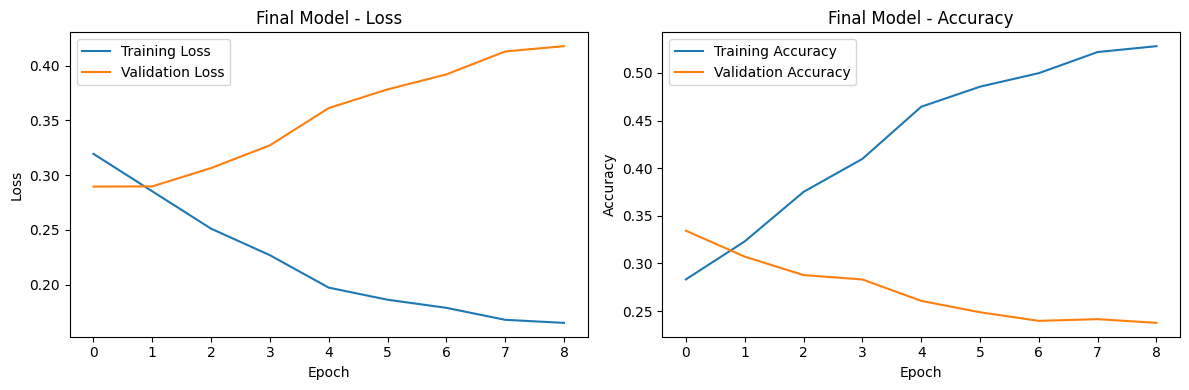

In [79]:
# Visualize final training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_v4.history['loss'], label='Training Loss')
plt.plot(history_v4.history['val_loss'], label='Validation Loss')
plt.title('Final Model - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_v4.history['accuracy'], label='Training Accuracy')
plt.plot(history_v4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Final Model - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [80]:
# Complete performance comparison
print("\n" + "=" * 70)
print("COMPLETE PERFORMANCE SUMMARY (External Test Set)")
print("=" * 70)
print(f"Baseline    - Macro F1: 0.1051 | Weighted F1: 0.3641 | Acc: 50.78%")
print(f"Iteration 2 - Macro F1: 0.0769 | Weighted F1: 0.0962 | Acc: 13.80%")
print(f"Iteration 3 - Macro F1: 0.1104 | Weighted F1: 0.3584 | Acc: 47.21%")
print(f"Iteration 4 - Macro F1: {f1_macro_v4:.4f} | Weighted F1: {f1_weighted_v4:.4f} | Acc: {np.mean(y_new_pred_classes_v4 == y_new_test_valid):.2%}")
print("=" * 70)


COMPLETE PERFORMANCE SUMMARY (External Test Set)
Baseline    - Macro F1: 0.1051 | Weighted F1: 0.3641 | Acc: 50.78%
Iteration 2 - Macro F1: 0.0769 | Weighted F1: 0.0962 | Acc: 13.80%
Iteration 3 - Macro F1: 0.1104 | Weighted F1: 0.3584 | Acc: 47.21%
Iteration 4 - Macro F1: 0.0984 | Weighted F1: 0.3615 | Acc: 52.50%
